In [ ]:
!pip install timm

In [ ]:
import torchvision
import torch
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import glob
import math
import timm
from PIL import ImageFilter
from einops import rearrange
from timm.loss import LabelSmoothingCrossEntropy

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 10
lr = 0.0001
batch_size = 32
num_workers = 4

In [ ]:
class_names = os.listdir('/content/drive/MyDrive/Data/Train/')
class_names.sort()
class_len = len(class_names)
print(class_len)

2


In [ ]:
class Sports_Dataset(Dataset):

    def __init__(self, dataset_name):
        self.dataset_name = dataset_name

        self.img_path = []
        for name in class_names:
            self.img_path.append(glob.glob('/content/drive/MyDrive/Data/{}/{}/*.png'.format(dataset_name, name)))
        self.img_path = sum(self.img_path, [])
        self.img_path.sort()

        self.labels = []
        for path in self.img_path:
            self.labels.append(class_names.index(path.split('/')[6]))
        self.labels = np.array(self.labels)

        self.img_transforms=transforms.Compose([
            transforms.ToTensor(), # if image.dtype is np.uint8, then it will be divided by 255
        ])

    def __getitem__(self, index):
        img = Image.open(self.img_path[index])
        if img.size != (224, 224):
            img = img.resize((224, 224), Image.BILINEAR)

        # Data augmentation
        if self.dataset_name == 'Train':
            if random.uniform(0, 1) < 0.2 or img.getbands()[0] == 'L': # Random gray-scale from 20%
                img = img.convert('L').convert('RGB')

            if random.uniform(0, 1) < 0.3: # Random crop from 30%
                img = img.resize((288, 288), Image.BILINEAR)
                x1 = random.randrange(0, 64)
                y1 = random.randrange(0, 64)
                img = img.crop((x1, y1, x1+224, y1+224))

            if random.uniform(0, 1) < 0.2: # Random Gaussian blur from 20%
                gaussianBlur = ImageFilter.GaussianBlur(random.uniform(0.5, 1.2))
                img = img.filter(gaussianBlur)

            if random.uniform(0, 1) < 0.3: # Random flip from 30%
                img = img.transpose(Image.FLIP_LEFT_RIGHT)
        else:
            if img.getbands()[0] == 'L':
                img = img.convert('L').convert('RGB')

        lbl = self.labels[index]

        img = self.img_transforms(img)
        lbl = torch.tensor(lbl)

        return img, lbl

    def __len__(self):

        return len(self.img_path)

In [ ]:
# prompt: perform data augmentation

import torchvision
import torch
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import glob
import math
import timm
from PIL import ImageFilter
from einops import rearrange
from timm.loss import LabelSmoothingCrossEntropy
!pip install timm
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 10
lr = 0.0001
batch_size = 32
num_workers = 4
class_names = os.listdir('/content/drive/MyDrive/Data/Train/')
class_names.sort()
class_len = len(class_names)
print(class_len)
class Sports_Dataset(Dataset):

    def __init__(self, dataset_name):
        self.dataset_name = dataset_name

        self.img_path = []
        for name in class_names:
            self.img_path.append(glob.glob('/content/drive/MyDrive/Data/{}/{}/*.png'.format(dataset_name, name)))
        self.img_path = sum(self.img_path, [])
        self.img_path.sort()

        self.labels = []
        for path in self.img_path:
            self.labels.append(class_names.index(path.split('/')[6]))
        self.labels = np.array(self.labels)

        self.img_transforms=transforms.Compose([
            transforms.ToTensor(), # if image.dtype is np.uint8, then it will be divided by 255
        ])

    def __getitem__(self, index):
        img = Image.open(self.img_path[index])
        if img.size != (224, 224):
            img = img.resize((224, 224), Image.BILINEAR)

        # Data augmentation
        if self.dataset_name == 'Train':
            if random.uniform(0, 1) < 0.2 or img.getbands()[0] == 'L': # Random gray-scale from 20%
                img = img.convert('L').convert('RGB')

            if random.uniform(0, 1) < 0.3: # Random crop from 30%
                img = img.resize((288, 288), Image.BILINEAR)
                x1 = random.randrange(0, 64)
                y1 = random.randrange(0, 64)
                img = img.crop((x1, y1, x1+224, y1+224))

            if random.uniform(0, 1) < 0.2: # Random Gaussian blur from 20%
                gaussianBlur = ImageFilter.GaussianBlur(random.uniform(0.5, 1.2))
                img = img.filter(gaussianBlur)

            if random.uniform(0, 1) < 0.3: # Random flip from 30%
                img = img.transpose(Image.FLIP_LEFT_RIGHT)
        else:
            if img.getbands()[0] == 'L':
                img = img.convert('L').convert('RGB')

        lbl = self.labels[index]

        img = self.img_transforms(img)
        lbl = torch.tensor(lbl)

        return img, lbl

    def __len__(self):

        return len(self.img_path)


2


2718


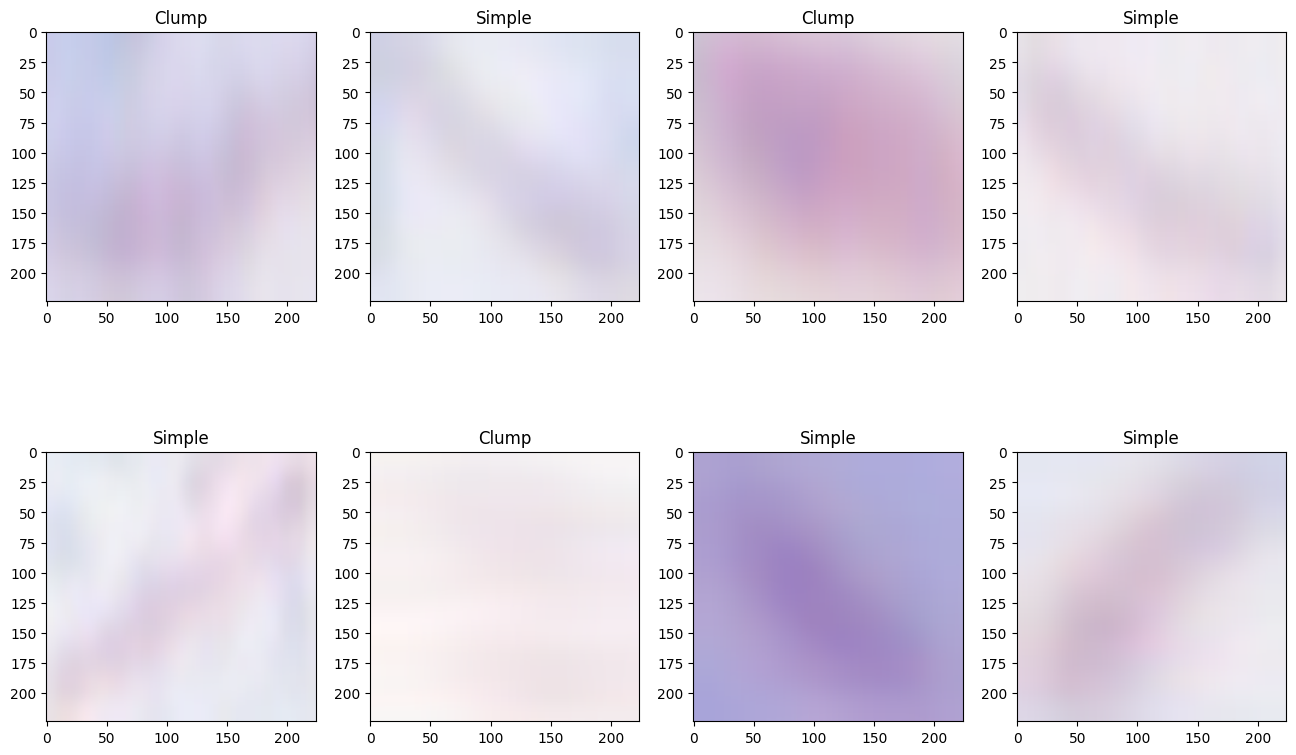

In [ ]:
train_dataset = Sports_Dataset('Train')
print(train_dataset.__len__())
_, ax = plt.subplots(2, 4, figsize=(16,10))

for i in range(8):
    data = train_dataset.__getitem__(np.random.choice(range(train_dataset.__len__())))

    image = data[0].cpu().detach().numpy().transpose(1, 2, 0) * 255
    image = image.astype(np.uint32)

    label = data[1]

    ax[i//4][i-(i//4)*4].imshow(image)
    ax[i//4][i-(i//4)*4].set_title(class_names[label])

In [ ]:
timm.list_models('swin*', pretrained=True)

['swin_base_patch4_window7_224.ms_in1k',
 'swin_base_patch4_window7_224.ms_in22k',
 'swin_base_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_base_patch4_window12_384.ms_in1k',
 'swin_base_patch4_window12_384.ms_in22k',
 'swin_base_patch4_window12_384.ms_in22k_ft_in1k',
 'swin_large_patch4_window7_224.ms_in22k',
 'swin_large_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_large_patch4_window12_384.ms_in22k',
 'swin_large_patch4_window12_384.ms_in22k_ft_in1k',
 'swin_s3_base_224.ms_in1k',
 'swin_s3_small_224.ms_in1k',
 'swin_s3_tiny_224.ms_in1k',
 'swin_small_patch4_window7_224.ms_in1k',
 'swin_small_patch4_window7_224.ms_in22k',
 'swin_small_patch4_window7_224.ms_in22k_ft_in1k',
 'swin_tiny_patch4_window7_224.ms_in1k',
 'swin_tiny_patch4_window7_224.ms_in22k',
 'swin_tiny_patch4_window7_224.ms_in22k_ft_in1k',
 'swinv2_base_window8_256.ms_in1k',
 'swinv2_base_window12_192.ms_in22k',
 'swinv2_base_window12to16_192to256.ms_in22k_ft_in1k',
 'swinv2_base_window12to24_192to384.ms_in22k_ft_in1k',


In [ ]:
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
model.head = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, class_len)) # Modify head according to this task

model = model.to(device)

criterion = LabelSmoothingCrossEntropy() # this is better than nn.CrossEntropyLoss
criterion = criterion.to(device)

optimizer = torch.optim.AdamW(model.head.parameters(), lr=lr) # Setting for transfer learning

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [ ]:
features = []

def hook(module, input, output):
    features.append(output)

In [ ]:
features = []

hook1 = model.layers[0].blocks[1].register_forward_hook(hook)
hook2 = model.layers[1].blocks[1].register_forward_hook(hook)
hook3 = model.layers[2].blocks[17].register_forward_hook(hook)
hook4 = model.layers[3].blocks[1].register_forward_hook(hook)

_ = model(data[0].unsqueeze(0).to(device))

hook1.remove()
hook2.remove()
hook3.remove()
hook4.remove()

In [ ]:
print(features[0].shape)
print(features[1].shape)
print(features[2].shape)
print(features[3].shape)

torch.Size([1, 56, 56, 128])
torch.Size([1, 28, 28, 256])
torch.Size([1, 14, 14, 512])
torch.Size([1, 7, 7, 1024])


In [ ]:
features[0] = rearrange(features[0], 'b h w c -> b c h w')
features[1] = rearrange(features[1], 'b h w c -> b c h w')
features[2] = rearrange(features[2], 'b h w c -> b c h w')
features[3] = rearrange(features[3], 'b h w c -> b c h w')

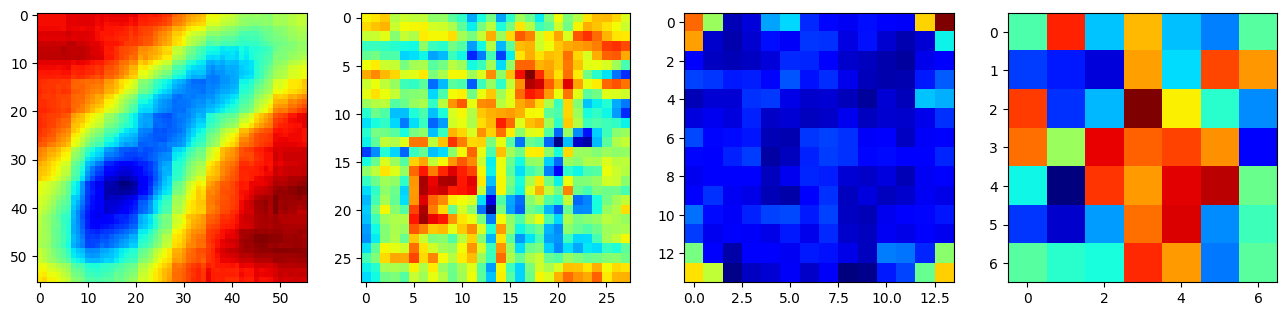

In [ ]:
_, ax = plt.subplots(1, 4, figsize=(16,10))
for i in range(len(features)):
    ax[i].imshow(features[i][0].transpose(0, 2).transpose(0, 1).sum(-1).detach().cpu().numpy(), cmap='jet')

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)

In [ ]:
val_dataset = Sports_Dataset('Valid')
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=1,
                                           shuffle=False)

In [ ]:
len(val_dataset)

111

In [ ]:
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

model.train()

total_step = len(train_loader)
curr_lr = lr
best_score = 0

for epoch in range(20):
    total_loss = 0

    # Training loop
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        g_labels = model(images)  # Get the model predictions

        # Apply global average pooling over spatial dimensions (7x7)
        g_labels = torch.mean(g_labels, dim=(1, 2))  # Now g_labels shape is [batch_size, num_classes]

        loss = criterion(g_labels, labels)  # Assuming CrossEntropyLoss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (i+1) % 100 == 0:
            print('{} / {}'.format(batch_size*(i+1), train_dataset.__len__()))

    # Evaluation loop
    model.eval()
    val_loss = 0
    correct_predictions = 0
    all_preds = []
    all_labels = []

    for i, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            g_labels = model(images)
            # Apply global average pooling to validation set too
            g_labels = torch.mean(g_labels, dim=(1, 2))

        val_loss += criterion(g_labels, labels).item()

        preds = torch.max(g_labels, 1)[1]  # Get the predicted class
        correct_predictions += (preds == labels).sum().item()

        # Collecting all predictions and labels for precision, recall, and f1 score
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = correct_predictions / len(val_dataset)

    # Calculate precision, recall, f1-score
    precision = precision_score(all_labels, all_preds, average='macro')  # Adjust average depending on your task (binary/multiclass)
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    # Print metrics
    print(f'Epoch: {epoch+1}, Loss: {total_loss / total_step:.4f}, Val Loss: {val_loss / len(val_loader):.4f}')
    print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}\n')

    # Save the best model
    if best_score < accuracy:
        best_score = accuracy
        torch.save(model.state_dict(), '/content/SwinTransformer.ckpt')

    model.train()

Epoch: 1, Loss: 0.5571, Val Loss: 0.4506
Accuracy: 0.88, Precision: 0.90, Recall: 0.87, F1 Score: 0.88

Epoch: 2, Loss: 0.4786, Val Loss: 0.4229
Accuracy: 0.89, Precision: 0.90, Recall: 0.88, F1 Score: 0.89

Epoch: 3, Loss: 0.4654, Val Loss: 0.4153
Accuracy: 0.88, Precision: 0.90, Recall: 0.87, F1 Score: 0.88

Epoch: 4, Loss: 0.4563, Val Loss: 0.4013
Accuracy: 0.88, Precision: 0.89, Recall: 0.87, F1 Score: 0.88

Epoch: 5, Loss: 0.4456, Val Loss: 0.3990
Accuracy: 0.90, Precision: 0.91, Recall: 0.89, F1 Score: 0.90

Epoch: 6, Loss: 0.4402, Val Loss: 0.3966
Accuracy: 0.90, Precision: 0.90, Recall: 0.89, F1 Score: 0.90

Epoch: 7, Loss: 0.4357, Val Loss: 0.4037
Accuracy: 0.90, Precision: 0.90, Recall: 0.89, F1 Score: 0.90

Epoch: 8, Loss: 0.4375, Val Loss: 0.3884
Accuracy: 0.89, Precision: 0.89, Recall: 0.88, F1 Score: 0.89

Epoch: 9, Loss: 0.4384, Val Loss: 0.3990
Accuracy: 0.90, Precision: 0.90, Recall: 0.89, F1 Score: 0.90

Epoch: 10, Loss: 0.4370, Val Loss: 0.3914
Accuracy: 0.87, Precis

In [ ]:
labels.shape

torch.Size([1])

In [ ]:
g_labels.shape

torch.Size([1, 2])

In [ ]:
model.eval()
model.load_state_dict(torch.load('/content/SwinTransformer.ckpt', map_location=device))

<ipython-input-22-da4353b32d4e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/SwinTransformer.ckpt', map_location=device))


<All keys matched successfully>

In [ ]:
test_dataset = Sports_Dataset('Test')
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=1,
                                           shuffle=False)

In [ ]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
y_true = []
y_pred = []
score = 0
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    g_labels = model(images)
    g_labels = torch.mean(g_labels, dim=(1, 2))

    # Get predicted labels
    preds = torch.max(g_labels, 1)[1]

    # Collect true and predicted labels for metrics calculation
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

    score += int(preds[0] == labels[0])

# Calculate accuracy
avg_accuracy = score / len(test_dataset)
print('Accuracy: {:.2f}\n'.format(avg_accuracy))

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the calculated metrics
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 Score: {:.2f}'.format(f1))


Accuracy: 0.84

Precision: 0.85
Recall: 0.84
F1 Score: 0.84


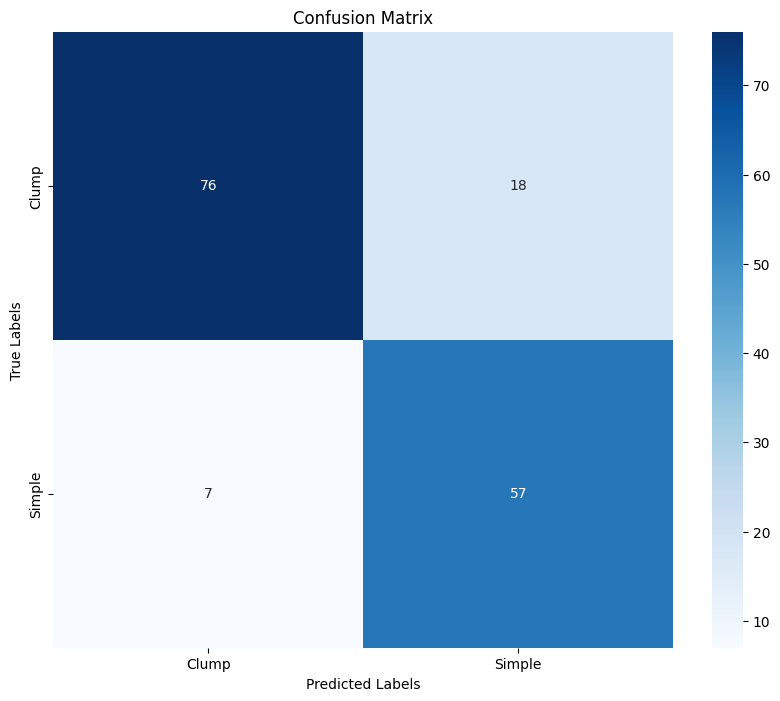

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming y_true and y_pred are already defined from your test loop
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()